# Assignment 3 - Pre-Processing

Jonathan Chia - jchia3 - due 9/17/2023

From the Kaggle web site (https://www.kaggle.com/datasets) download the Suicide Rates
Overview 1985 to 2016 dataset. 

This dataset has 12 features, and 27820 data points. 

We
would like to develop a machine learned model to predict, given some feature vectors, if the
outcome would be suicide or not, as a binary dependent variable. The category can be {"low
suicide rate", "high suicide rate"}. 

Note that, another approach can be generating a numerical
value by solving a regression problem.

A machine learning solution would require to pre-process the dataset and prepare/design our
experimentation.

Load the data set in your model development framework and examine the features. Note that
the Kaggle website also has histograms that you can inspect. However, you might want to look
at the data grouped by some other features. For example, how does the 'number of suicides
/ 100k' histogram look like from country to country?

To answer the following questions, you have to think thoroughly, and possibly attempt some
pilot experiments. There is no right or wrong answer to some questions below but you have to
convince your audience with your answers scholarly.

In [1]:
# Read in the data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
suicide_df = pd.read_csv('suicide.csv')

suicide_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
suicide_df.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

# 1. [10 pts] Due to the severity of this real-world crisis, what information would be the most important to "machine learn"? 

*Can it be learned? (Note that this is asking you to define the big-picture question that we want to answer from this dataset. This is not asking you to conjecture which feature is going to turn out being important.)*


The most important information to machine learn would be variables that we can affect. A government can affect the HDI or GDP.

I think we could add some actionable variables like school quality, crime rates, access to healthcare, access to guns, etc.

Since we don't have those, we can take a look at HDI and GDP first:

### HDI

My assumption is that when HDI is higher, there's less suicides. We can see that around .9 and higher, suicide rates are indeed lower - not getting past 75. 

On the lower end of HDI, suicides are also lower.

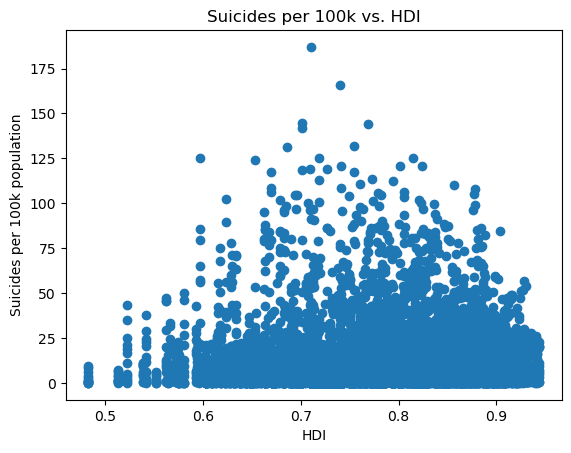

In [4]:
plt.scatter(suicide_df["HDI for year"], suicide_df["suicides/100k pop"])
plt.title('Suicides per 100k vs. HDI')
plt.xlabel('HDI')
plt.ylabel('Suicides per 100k population')
plt.show()

### GDP

There's a pretty obvious trend here. 

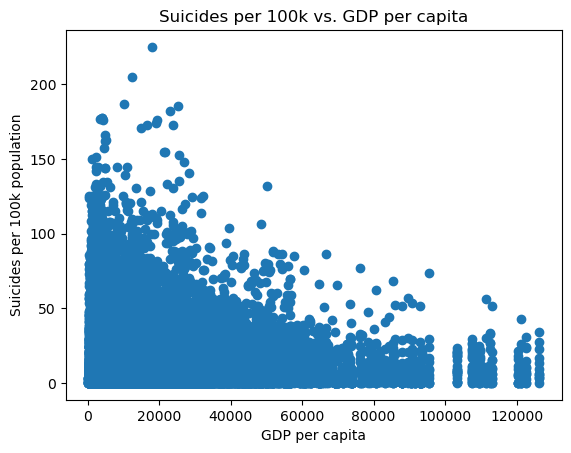

In [5]:
plt.scatter(suicide_df["gdp_per_capita ($)"], suicide_df["suicides/100k pop"])
plt.title('Suicides per 100k vs. GDP per capita')
plt.xlabel('GDP per capita')
plt.ylabel('Suicides per 100k population')
plt.show()


# 2. [10 pts] Explain in detail how one should set up the problem? 

*Would it be a regression or a classification problem? Any unsupervised approach to see some patterns exist or not?*



I think a regression would give us more useful predictions. Additionally, we could use the regression model to rank the countries from worst to best by different cohorts. We could technically do this with classification (count how many 'high suicide rate' cohorts there are per country but there would potentially be more ties).

Since the dependent variable, suicide per 100k, is a float, we can do a regression. Or, we could transform the variable to 'high suicide' vs. 'low suicide' to make it a classification problem.

Let's try clustering using the lecture notes code to see if there's any patterns we can find.

### Organize the data

In [6]:
X = suicide_df.drop(['suicides/100k pop', 'suicides_no', ' gdp_for_year ($) '], axis=1)
y = suicide_df["suicides/100k pop"]

s = (X.dtypes == 'object')
categorical_columns = list(s[s].index)

s = (X.dtypes == 'float64') | (X.dtypes == 'int64')
numerical_columns = list(s[s].index)

print(numerical_columns)

['year', 'population', 'HDI for year', 'gdp_per_capita ($)']


Let's turn these into useful functions I can use later

In [7]:
def list_categorical_columns(df):
    s = (df.dtypes == 'object')
    categorical_columns = list(s[s].index)
    return categorical_columns

def list_numerical_columns(df):
    s = (X.dtypes == 'float64') | (X.dtypes == 'int64')
    numerical_columns = list(s[s].index)
    return numerical_columns

### Turn Y variable into binary nominal variable

<Axes: >

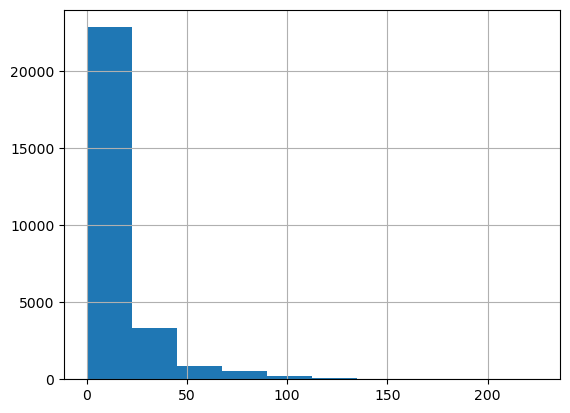

In [8]:
y.hist()

Lets just say that we will split it by the median. Anything above the median is high suicide and anything below the median is low suicide.

In [9]:
median_value = y.median()
y_nominal = y.apply(lambda x: 'high' if x >= median_value else 'low')

In [10]:
print(y.head())

print(y_nominal.head())

0    6.71
1    5.19
2    4.83
3    4.59
4    3.28
Name: suicides/100k pop, dtype: float64
0    high
1     low
2     low
3     low
4     low
Name: suicides/100k pop, dtype: object


In [11]:
y_nominal = y_nominal.astype("category").cat.codes

### Preprocess the data - pipelines

Using pipelines from kaggle tutorial: https://www.kaggle.com/code/alexisbcook/pipelines

In [12]:
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [13]:
my_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_transformed = my_preprocessing_pipeline.fit_transform(X)

### Run the model

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

def kmeans(_X, _y, niter):  # do it niter times to collect statistics
    accuracies = []
    for _ in range(niter):
        # We know that there are two levels in target variable - thus n_clusters=2
        km = KMeans(n_clusters=2, random_state=0, n_init=10)
        clusters = km.fit_predict(_X)
        accuracies += [accuracy_score(_y, clusters)]
    return np.mean(accuracies)

print(f'Clustering error= {kmeans(X_transformed, y_nominal, 100):.3f}')

Clustering error= 0.490


Well this tells us that the data isn't really clusterable

# 3. [20 pts] What should be the dependent variable?



I think the dependent variable should be suicide per 100k. I think this helps us view each cohort on an equal level. Some cohorts will have high suicide_no because they have a high population.

We can, however, try modeling suicide_no and just have population as an independent variable. It could potentially be better because it could find the interaction between population and other variables. 

For example, population may not have as much of a correlation with suicide for certain countries. 

Let's take a look at the variable

In [15]:
suicide_df[['suicides_no', 'suicides/100k pop']].describe()

,suicides_no,suicides/100k pop
count,27820.000000,27820.000000
mean,242.574407,12.816097
std,902.047917,18.961511
min,0.000000,0.000000
25%,3.000000,0.920000
50%,25.000000,5.990000
75%,131.000000,16.620000
max,22338.000000,224.970000


array([[<Axes: title={'center': 'suicides_no'}>,
        <Axes: title={'center': 'suicides/100k pop'}>]], dtype=object)

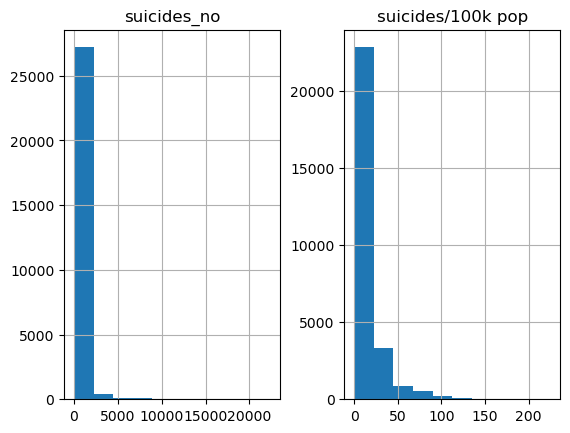

In [16]:
suicide_df[['suicides_no', 'suicides/100k pop']].hist()

The distribution is more skewed for suicides_no, so I think I will stick with trying suicides/100k pop.

# 5. [20 pts] Pre-process the dataset and list the major features you want to use. 

*Note that not all features are crucial.*

*For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country-year together.*

*In fact, one must avoid adding a derived feature and the original at the same time.*
*List the independent features you want to use.*



In [17]:
suicide_df.head(1)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X


Let's use the following features:

* country
* year
* sex
* age
* HDI
* gdp per capita
* generation

### Preprocessing

In [18]:
X = suicide_df.drop(['suicides/100k pop', 'suicides_no', ' gdp_for_year ($) ', 'country-year', 'population'], axis=1)
y = suicide_df["suicides/100k pop"]

In [19]:
categorical_cols = list_categorical_columns(X)
numerical_cols = list_numerical_columns(X)

print(categorical_cols)
print(numerical_cols)

['country', 'sex', 'age', 'generation']
['year', 'HDI for year', 'gdp_per_capita ($)']


Hmm we may want to count year as a categorical variable. Might even want to discretize it. Let's use it as is for now.

In [20]:
numerical_transformer = SimpleImputer(strategy='mean') # mean imputation for missing numericals
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # mode imputation for missing categoricals
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [21]:
my_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_transformed = my_preprocessing_pipeline.fit_transform(X)

In [22]:
X_transformed

<27820x118 sparse matrix of type '<class 'numpy.float64'>'
	with 194740 stored elements in Compressed Sparse Row format>

Let's see what it looks like

In [23]:
X_transformed_df = pd.DataFrame(X_transformed.toarray(), columns=preprocessor.get_feature_names_out())

In [24]:
X_transformed_df.head()

,num__year,num__HDI for year,num__gdp_per_capita ($),cat__country_Albania,cat__country_Antigua and Barbuda,cat__country_Argentina,cat__country_Armenia,cat__country_Aruba,cat__country_Australia,cat__country_Austria,...,cat__age_35-54 years,cat__age_5-14 years,cat__age_55-74 years,cat__age_75+ years,cat__generation_Boomers,cat__generation_G.I. Generation,cat__generation_Generation X,cat__generation_Generation Z,cat__generation_Millenials,cat__generation_Silent
0,1987.0,0.776601,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1987.0,0.776601,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1987.0,0.776601,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1987.0,0.776601,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1987.0,0.776601,796.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 6. [20 pts] Devise a classification problem and present a prototype model.

In [25]:
median_value = y.median()
y_nominal = y.apply(lambda x: 'high' if x >= median_value else 'low')
y_nominal = y_nominal.astype("category").cat.codes

Now the data is balanced, so we can use regular kfold evaluation

<Axes: >

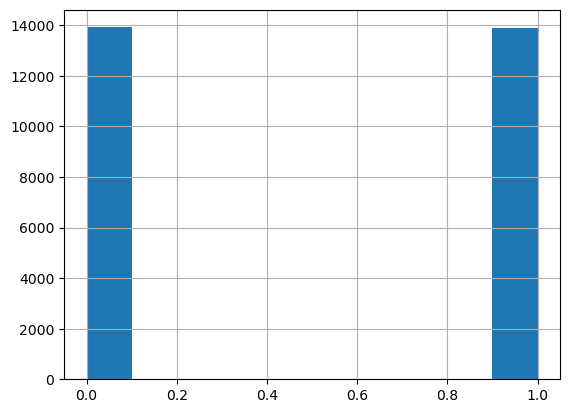

In [26]:
y_nominal.hist()

## Try some different models

Let's try a random forest first, and then we can try a naive bayes with standardized features

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  # f1_score can be used too
from sklearn.model_selection import KFold, train_test_split

# Function from class
def rf_train_test(_X_tr, _X_ts, _y_tr, _y_ts):
    # Create a new random forest classifier, with working 4 parallel cores
    rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0, n_jobs=4)
    # Train on training data
    rf.fit(_X_tr, _y_tr)
    # Test on training data
    y_pred = rf.predict(_X_ts)
    # Return more proper evaluation metric
    # return f1_score(_y_ts, y_pred, pos_label='recurrence-events', zero_division=0)
    # Return accuracy
    return accuracy_score(_y_ts, y_pred)

In [28]:
%%time

# 10-fold cross validation
Accuracies = []
kfold = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kfold.split(X_transformed, y_nominal):
    acc = rf_train_test(X_transformed[train_index], X_transformed[test_index], y_nominal[train_index], y_nominal[test_index])
    Accuracies += [acc]

print(f'10-fold cross validation accuracy is {np.mean(Accuracies):.3f} {chr(177)}{np.std(Accuracies):.4f}')

10-fold cross validation accuracy is 0.765 ±0.0427
CPU times: total: 2.95 s
Wall time: 7.63 s


Ok not bad. Let's try a naive bayes model instead

## Naive Bayes Preprocessing

In [29]:
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps = [
    ('mean_imputer', SimpleImputer(strategy='mean')),# mean imputation for missing numericals
    ('standardizer', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # mode imputation for missing categoricals
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

naive_bayes_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [30]:
nb_preprocessing_pipeline = Pipeline(steps=[('preprocessor', naive_bayes_preprocessor)])

X_transformed_nb = nb_preprocessing_pipeline.fit_transform(X)

Let's see what it looks like

In [31]:
X_transformed_nb_df = pd.DataFrame(X_transformed_nb.toarray(), columns=naive_bayes_preprocessor.get_feature_names_out())

In [32]:
X_transformed_nb_df.head()

,num__year,num__HDI for year,num__gdp_per_capita ($),cat__country_Albania,cat__country_Antigua and Barbuda,cat__country_Argentina,cat__country_Armenia,cat__country_Aruba,cat__country_Australia,cat__country_Austria,...,cat__age_35-54 years,cat__age_5-14 years,cat__age_55-74 years,cat__age_75+ years,cat__generation_Boomers,cat__generation_G.I. Generation,cat__generation_Generation X,cat__generation_Generation Z,cat__generation_Millenials,cat__generation_Silent
0,-1.683615,-2.168781e-15,-0.850864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.683615,-2.168781e-15,-0.850864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.683615,-2.168781e-15,-0.850864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.683615,-2.168781e-15,-0.850864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.683615,-2.168781e-15,-0.850864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Yeah here I think standardizing year is really weird

In [33]:
from sklearn.naive_bayes import GaussianNB

# Function from class
def nb_train_test(_X_tr, _X_ts, _y_tr, _y_ts):
    # Create a new random forest classifier, with working 4 parallel cores
    nb = GaussianNB()
    # Train on training data
    nb.fit(_X_tr.toarray(), _y_tr)
    # Test on training data
    y_pred = nb.predict(_X_ts.toarray())
    # Return more proper evaluation metric
    # return f1_score(_y_ts, y_pred, pos_label='recurrence-events', zero_division=0)
    # Return accuracy
    return accuracy_score(_y_ts, y_pred)

In [34]:
%%time

# 10-fold cross validation
Accuracies = []
kfold = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kfold.split(X_transformed_nb, y_nominal):
    acc = nb_train_test(X_transformed_nb[train_index], X_transformed_nb[test_index], y_nominal[train_index], y_nominal[test_index])
    Accuracies += [acc]

print(f'10-fold cross validation accuracy is {np.mean(Accuracies):.3f} {chr(177)}{np.std(Accuracies):.4f}')

10-fold cross validation accuracy is 0.669 ±0.0633
CPU times: total: 391 ms
Wall time: 728 ms


Well it did worse than the random forest, likely because random forest is more robust

## Improve the preprocessing for random forest

Let's try discretizing the year into buckets

In [35]:
1961 // 5 * 5

1960

In [36]:
X['year'] = X.year.apply(lambda year: f"{year // 5 * 5}-{(year // 5 + 1) * 5 - 1}")

In [37]:
X.year.head()

0    1985-1989
1    1985-1989
2    1985-1989
3    1985-1989
4    1985-1989
Name: year, dtype: object

In [38]:
categorical_cols = list_categorical_columns(X)
numerical_cols = list_numerical_columns(X)

numerical_transformer = SimpleImputer(strategy='mean') # mean imputation for missing numericals
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # mode imputation for missing categoricals
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
my_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_transformed = my_preprocessing_pipeline.fit_transform(X)

In [39]:
%%time

# 10-fold cross validation
Accuracies = []
kfold = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kfold.split(X_transformed, y_nominal):
    acc = rf_train_test(X_transformed[train_index], X_transformed[test_index], y_nominal[train_index], y_nominal[test_index])
    Accuracies += [acc]

print(f'10-fold cross validation accuracy is {np.mean(Accuracies):.3f} {chr(177)}{np.std(Accuracies):.4f}')

10-fold cross validation accuracy is 0.764 ±0.0433
CPU times: total: 3.17 s
Wall time: 7.17 s


Huh that didn't really help that much

I would assume suicide rates have increased over time

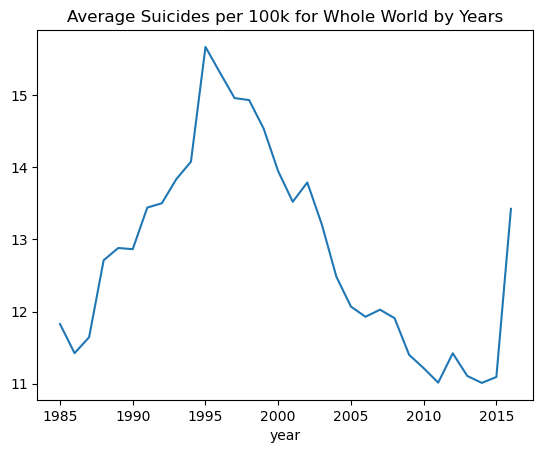

In [40]:
suicide_df.groupby('year')['suicides/100k pop'].mean().plot()
plt.title('Average Suicides per 100k for Whole World by Years')
plt.show()

# 4. [20 pts] Rank the variables to find some strong correlations 

*between the independent variables and the dependent variable you decided.*



## Correlation

In [41]:
suicide_df[numerical_cols+['suicides/100k pop']].corr()

,HDI for year,gdp_per_capita ($),suicides/100k pop
HDI for year,1.000000,0.771228,0.074279
gdp_per_capita ($),0.771228,1.000000,0.001785
suicides/100k pop,0.074279,0.001785,1.000000


Oh there's hardly a correlation for gdp and hdi

What does the model tell us is an important variable?

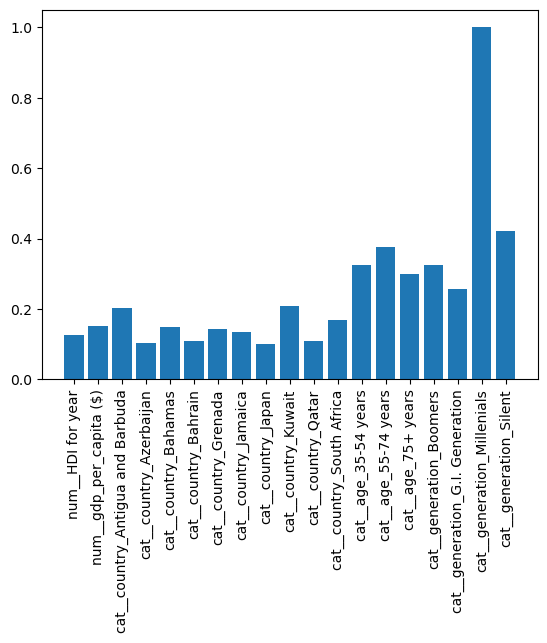

In [42]:
from sklearn.feature_selection import SelectPercentile, f_classif


selector = SelectPercentile(f_classif, percentile=10)
# Fit the data
selector.fit(X_transformed, y_nominal)
scores = -np.log10(selector.pvalues_[selector.pvalues_ != 0])
cols = preprocessor.get_feature_names_out()[selector.pvalues_ != 0]
scores /= scores.max()
filtered_scores = scores[scores >= 0.1]

# Display
cols = list(cols[scores >= 0.1])
y_pos = np.arange(len(cols))
plt.bar(y_pos, filtered_scores)
plt.xticks(y_pos, cols, rotation=90)
plt.show()

Looks like the generation variables are pretty insightful

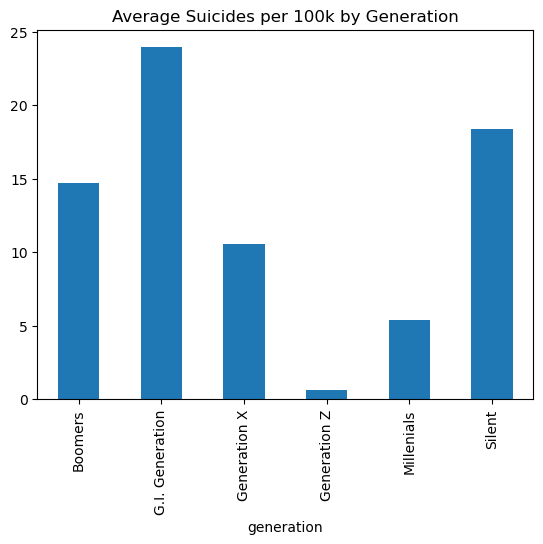

In [43]:
suicide_df.groupby('generation')['suicides/100k pop'].mean().plot(kind='bar')
plt.title('Average Suicides per 100k by Generation')
plt.show()

Looks like age is pretty important too

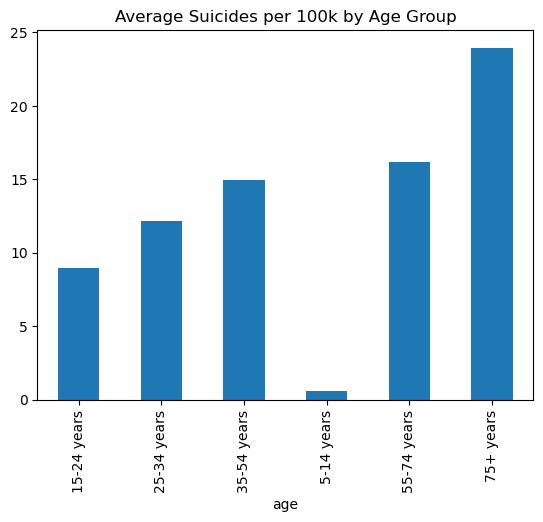

In [44]:
suicide_df.groupby('age')['suicides/100k pop'].mean().plot(kind='bar')
plt.title('Average Suicides per 100k by Age Group')
plt.show()

So, based on the SelectPercentile() function, here is the ranking of the most important variables:

* Generation
* Age
* Country
* GDP 
* HDI

I bet we can take out generation because it relates to age. We can also probably exclude sex as well.

Let's look at sex though

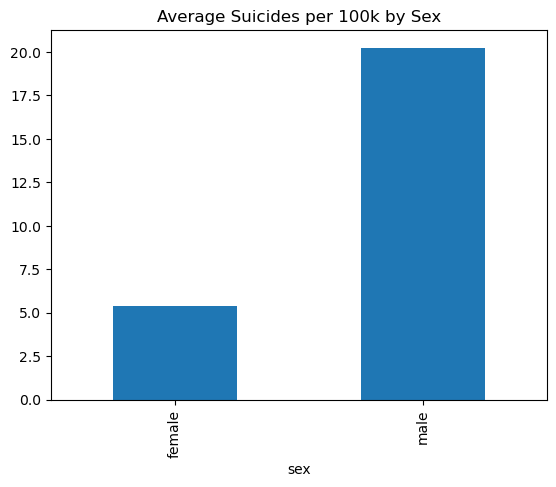

In [45]:
suicide_df.groupby('sex')['suicides/100k pop'].mean().plot(kind='bar')
plt.title('Average Suicides per 100k by Sex')
plt.show()

Huh you would think that the gender would have a bigger impact in the model

## Comparison with Random Forest Variable Importance

In [46]:
rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0, n_jobs=4)
rf.fit(X_transformed, y_nominal)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=4, random_state=0)

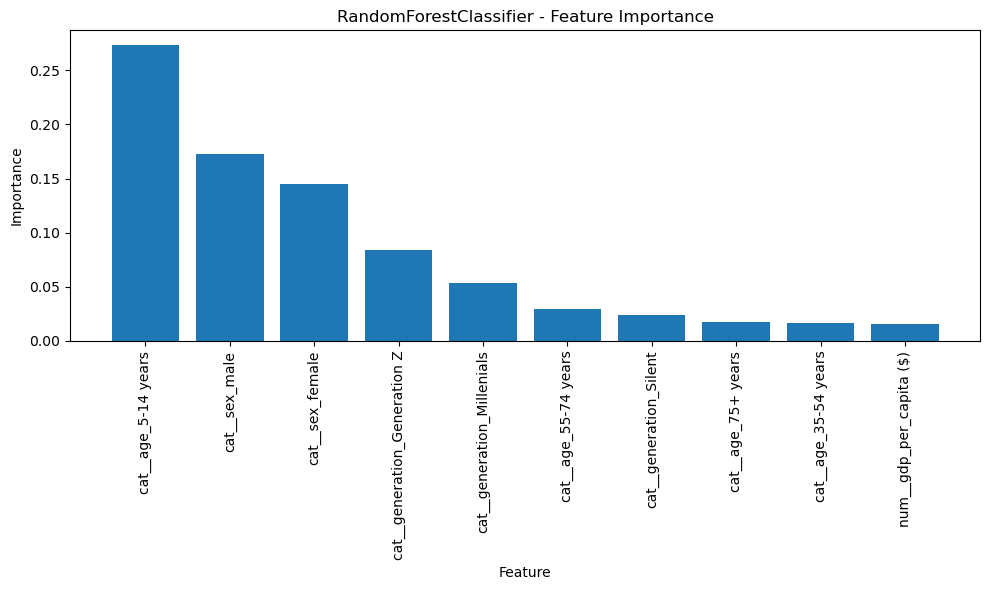

In [47]:
importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Sort the feature importances in descending order and get the corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[i] for i in indices]
sorted_feature_names = [feature_names[i] for i in indices]

# Create a bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(0,10), sorted_importances[0:10], align="center")
plt.xticks(range(0,10), sorted_feature_names[0:10], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("RandomForestClassifier - Feature Importance")
plt.tight_layout()
plt.show()

Based on Random Forest Variable Importance, I would also say that sex is important to the model

# Fit final model using reduced featureset

In [48]:
X = suicide_df.drop(['suicides/100k pop', 'suicides_no', ' gdp_for_year ($) ', 'country-year', 'population', 'generation'], axis=1)
X['year'] = X.year.apply(lambda year: f"{year // 5 * 5}-{(year // 5 + 1) * 5 - 1}")

In [49]:
categorical_cols = list_categorical_columns(X)
numerical_cols = list_numerical_columns(X)

numerical_transformer = SimpleImputer(strategy='mean') # mean imputation for missing numericals
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # mode imputation for missing categoricals
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
my_preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_transformed = my_preprocessing_pipeline.fit_transform(X)

In [50]:
%%time

# 10-fold cross validation
Accuracies = []
kfold = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kfold.split(X_transformed, y_nominal):
    acc = rf_train_test(X_transformed[train_index], X_transformed[test_index], y_nominal[train_index], y_nominal[test_index])
    Accuracies += [acc]

print(f'10-fold cross validation accuracy is {np.mean(Accuracies):.3f} {chr(177)}{np.std(Accuracies):.4f}')

10-fold cross validation accuracy is 0.763 ±0.0436
CPU times: total: 2.81 s
Wall time: 7.59 s


The model did about as good despite having less features

Final thoughts:

I think running this as a regression might be more informative and accurate. The model could potentially be struggling with the suicide rates that are more in the middle. 

I would also try using different dependent variable of suicide_no and adding population into the model.